# **Harleen Kaur Bagga**

# A simple Python zero-coupon bond calculator

In [50]:
#A zero-coupon bond is a bond that does not pay any periodic interest except on 
#maturity, where the principal or face value is repaid.
def zero_coupon_bond(par, y, t):#zero_coupon_bond function  with par(face value),y(annual yield),t(time of maturity) as parameters
    """
    Price a zero coupon bond.
    
    :param par: face value of the bond.
    :param y: annual yield or rate of the bond.
    :param t: time to maturity, in years.
    """
    return par/(1+y)**t#price of zero coupon bond=face value/(1+annual yield)^(time of maturity)

In [51]:
print(zero_coupon_bond(100, 0.05, 5))#print the amount investor invested at annual inteest rate of 5% for 5 years

78.35261664684589


# Bootstrapping a yield curve

In [52]:
import math#to use mathematical functions we have to import math

class BootstrapYieldCurve(object):    
    
    def __init__(self):
        self.zero_rates = dict()#Map each T to a zero rate
        self.instruments = dict()#Map each T to an interest
        
    def add_instrument(self, par, T, coup, price, compounding_freq=2):
        """  Save instrument info by maturity
        """
        self.instruments[T] = (par, coup, price, compounding_freq)
    
    def get_maturities(self):
        """ 
        :return: a list of maturities of added instruments 
        """
        return sorted(self.instruments.keys())
    
    def get_zero_rates(self):
        """ 
        Returns a list of spot rates on the yield curve.
        """
        self.bootstrap_zero_coupons()    
        self.get_bond_spot_rates()
        return [self.zero_rates[T] for T in self.get_maturities()]    
        
    def bootstrap_zero_coupons(self):
        """ 
        Bootstrap the yield curve with zero coupon instruments first.
        """
        for (T, instrument) in self.instruments.items():
            (par, coup, price, freq) = instrument
            if coup == 0:
                spot_rate = self.zero_coupon_spot_rate(par, price, T)
                self.zero_rates[T] = spot_rate        
                
    def zero_coupon_spot_rate(self, par, price, T):
        """ 
        :return: the zero coupon spot rate with continuous compounding.
        """
        spot_rate = math.log(par/price)/T
        return spot_rate
                    
    def get_bond_spot_rates(self):
        """ 
        Get spot rates implied by bonds, using short-term instruments.
        """
        for T in self.get_maturities():
            instrument = self.instruments[T]
            (par, coup, price, freq) = instrument
            if coup != 0:
                spot_rate = self.calculate_bond_spot_rate(T, instrument)
                self.zero_rates[T] = spot_rate
                
    def calculate_bond_spot_rate(self, T, instrument):
        """
        Spot rate of a bond calculated by bootstraping
        """
        try:
            (par, coup, price, freq) = instrument
            periods = T*freq#no. of coupon payments
            value = price
            per_coupon = coup/freq#coupon payments per period
            for i in range(int(periods)-1):
                t = (i+1)/float(freq)
                spot_rate = self.zero_rates[t]
                discounted_coupon = per_coupon*math.exp(-spot_rate*t)
                value -= discounted_coupon
             #derive spot rate for a particular maturity
            last_period = int(periods)/float(freq)        
            spot_rate = -math.log(value/(par+per_coupon))/last_period
            return spot_rate
        except:
            print("Error: spot rate not found for T=", t)
            


In [53]:
yield_curve = BootstrapYieldCurve()#instantiate BootstrapYieldCurve class and add each bonds information
yield_curve.add_instrument(100, 0.25, 0., 97.5)
yield_curve.add_instrument(100, 0.5, 0., 94.9)
yield_curve.add_instrument(100, 1.0, 0., 90.)
yield_curve.add_instrument(100, 1.5, 8, 96., 2)
yield_curve.add_instrument(100, 2., 12, 101.6, 2)

In [54]:
#get_zero_rates method returns a list of spot rates in the same order as the maturities
#the returned value is stored in y and x variables respectively
y = yield_curve.get_zero_rates()
x = yield_curve.get_maturities()

Populating the interactive namespace from numpy and matplotlib


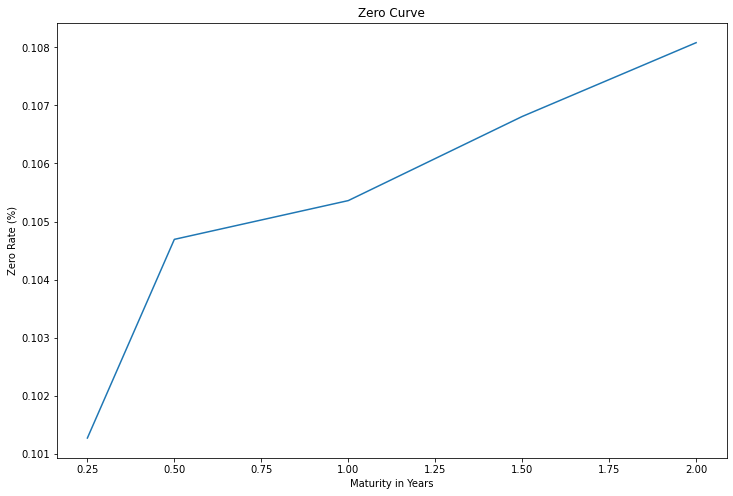

In [55]:
 #by invoking %pylab IPython interpreter will import matplotlib and NumPy modules 
%pylab inline

fig = plt.figure(figsize=(12, 8))
plot(x, y)#plot the chart
title("Zero Curve") #title of the chart
ylabel("Zero Rate (%)")#Y curve labelling Zero rate
xlabel("Maturity in Years");#X curve labelling Maturity in Years

# Forward rates

In [56]:
#class to generate a list of forward rates from a list of spot rates
class ForwardRates(object):
    
    def __init__(self):
        self.forward_rates = []
        self.spot_rates = dict()
        
    def add_spot_rate(self, T, spot_rate):
        self.spot_rates[T] = spot_rate
        
    def get_forward_rates(self):#gets a list of forward rates ,starting from next time period
        """
        Returns a list of forward rates
        starting from the second time period.
        """
        periods = sorted(self.spot_rates.keys())
        for T2, T1 in zip(periods, periods[1:]):
            forward_rate = self.calculate_forward_rate(T1, T2)
            self.forward_rates.append(forward_rate)

        return self.forward_rates
    #
    
    def calculate_forward_rate(self, T1, T2):
        R1 = self.spot_rates[T1]#continously compounded annual interest rates for time period T1
        R2 = self.spot_rates[T2]#continously compounded annual interest rates for time period T2
        forward_rate = (R2*T2-R1*T1)/(T2-T1)#forward rate= (R2xT2 - R1xT1)/(T2-T1)
        return forward_rate        

In [57]:
#instantiate ForwardRates() and  call add_spot_rate to add the spot rate information to a dictionary
fr = ForwardRates()
fr.add_spot_rate(0.25, 10.127)
fr.add_spot_rate(0.50, 10.469)
fr.add_spot_rate(1.00, 10.536)
fr.add_spot_rate(1.50, 10.681)
fr.add_spot_rate(2.00, 10.808)

In [58]:
print(fr.get_forward_rates())#print the list of forward rates satrting from next time period

[10.810999999999998, 10.603, 10.971, 11.189]


# Calculating the yield to maturity

In [59]:
#get yield to maturity of a bond
#YTM calculator that can help us compare a bond's expected return with those of other securities.
import scipy.optimize as optimize#Scipy optimize provides functions for minimizing (or maximizing) objective functions

def bond_ytm(price, par, T, coup, freq=2, guess=0.05):
    freq = float(freq)
    periods = T*2
    coupon = coup/100.*par
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: \
        sum([coupon/freq/(1+y/freq)**(freq*t) for t in dt]) +\  
        par/(1+y/freq)**(freq*T) - price    #Yield to maturity is calculated here
   #T is the time period of payment in years
   #freq is the coupon payment frequency
   #y is the YTM we are interested in solving 
    return optimize.newton(ytm_func, guess)

In [60]:
ytm = bond_ytm(95.0428, 100, 1.5, 5.75, 2)#bond_ytm method instantiated

In [61]:
print(ytm)#print yield to maturity 

0.09369155345239477


# Calculating the price of a bond

In [62]:
def bond_price(par, T, ytm, coup, freq=2):
    freq = float(freq)
    periods = T*2
    coupon = coup/100.*par
    dt = [(i+1)/freq for i in range(int(periods))]
    price = sum([coupon/freq/(1+ytm/freq)**(freq*t) for t in dt]) + \
        par/(1+ytm/freq)**(freq*T) #Bond price is claculated here
    return price

In [63]:
price = bond_price(100, 1.5, ytm, 5.75, 2)#bond_price method instantiated
print(price)#print price of the bond

95.04280000000004


# Bond duration

In [64]:
def bond_mod_duration(price, par, T, coup, freq, dy=0.01):
    ytm = bond_ytm(price, par, T, coup, freq)
    #dy is the change in the yield
    ytm_minus = ytm - dy  #decrese the yield by dy  
    price_minus = bond_price(par, T, ytm_minus, coup, freq)#price of the bond from decrese in the yield
    
    ytm_plus = ytm + dy#increase the yield by dy
    price_plus = bond_price(par, T, ytm_plus, coup, freq)#price of the bond from the increase in the yield
    
    mduration = (price_minus-price_plus)/(2*price*dy)#modified duration of the bond evaluated
                                          
    return mduration

In [65]:
mod_duration = bond_mod_duration(95.0428, 100, 1.5, 5.75, 2)#modified duration value updated
print(mod_duration)#print modified duration

1.3921935426560885


# Bond convexity

In [66]:
#Convexity is the sensitivity measure of the duration of a bond to yield changes
def bond_convexity(price, par, T, coup, freq, dy=0.01):
    ytm = bond_ytm(price, par, T, coup, freq)#bond 

    ytm_minus = ytm - dy  #decrese the yield by dy   
    price_minus = bond_price(par, T, ytm_minus, coup, freq)#price of the bond from decrese in the yield
    
    ytm_plus = ytm + dy#increase the yield by dy
    price_plus = bond_price(par, T, ytm_plus, coup, freq)#price of the bond from increase in the yield
    
    convexity = (price_minus + price_plus - 2*price)/(price*dy**2)#convexity value evaluated and updated
    return convexity

# Short-rate modeling

## The Vasicek model

In [67]:
import math#to use mathematical functions we have to import math
import numpy as np#Numpy provides fast mathematical function processing

def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):    
    np.random.seed(seed)#normal random number generator using seed
    dt = T/float(N)    #generate dt time increment
    rates = [r0]#initial rate of interest
    #loop to find short rate
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + \
            sigma*math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1]+dr)
        
    return range(N+1), rates

Populating the interactive namespace from numpy and matplotlib


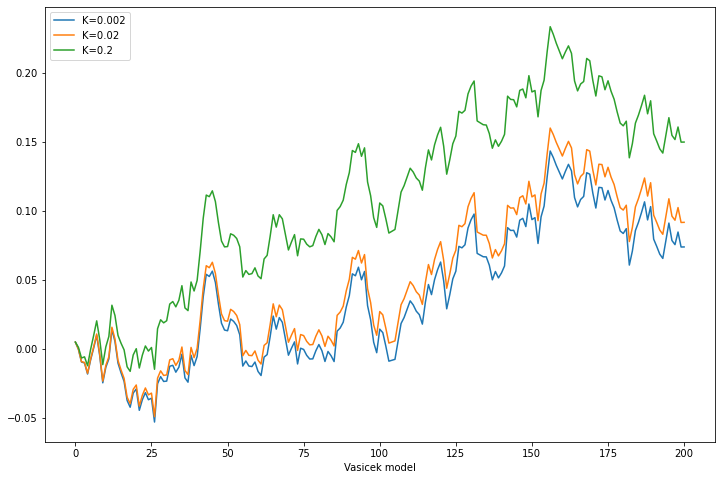

In [68]:
#by invoking %pylab IPython interpreter will import matplotlib and NumPy modules
%pylab inline
#plot
fig = plt.figure(figsize=(12, 8))
#loop to plot charts for different values of constant K
for K in [0.002, 0.02, 0.2]:
    x, y = vasicek(0.005, K, 0.15, 0.05, T=10, N=200)#vasicek method called
    plot(x,y, label='K=%s'%K)
    pylab.legend(loc='upper left');
    
pylab.legend(loc='upper left')
pylab.xlabel('Vasicek model');

## The Cox-Ingersoll-Ross model

In [69]:
import math#to use mathematical functions we have to import math
import numpy as np#Numpy provides fast mathematical function processing

def CIR(r0, K, theta, sigma, T=1.,N=10,seed=777):        
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + \
            sigma*math.sqrt(rates[-1])*\
            math.sqrt(dt)*np.random.normal()#short rate calculated using the stochastic differential equation
        rates.append(rates[-1] + dr)
        
    return range(N+1), rates

Populating the interactive namespace from numpy and matplotlib


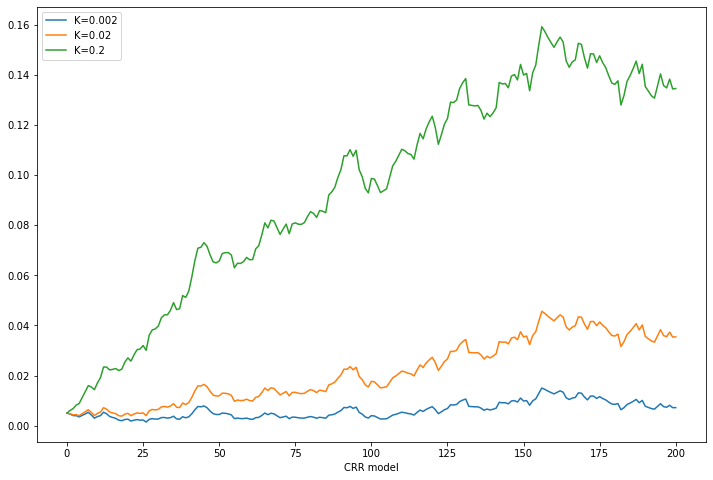

In [70]:
#by invoking %pylab IPython interpreter will import matplotlib and NumPy modules
%pylab inline

fig = plt.figure(figsize=(12, 8))

for K in [0.002, 0.02, 0.2]:
    x, y = CIR(0.005, K, 0.15, 0.05, T=10, N=200)#update values of x ,y based on CIR function
    plot(x,y, label='K=%s'%K)#plot the chart for different values of K
    
pylab.legend(loc='upper left')
pylab.xlabel('CRR model');

## The Rendleman and Bartter model

In [71]:
import math#to use mathematical functions we have to import math
import numpy as np#Numpy provides fast mathematical function processing
#theta is the instantaneous drift , sigma is instanatneous standard deviation
def rendleman_bartter(r0, theta, sigma, T=1.,N=10,seed=777):        
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    #loop to evalute short rate e
    for i in range(N):
        dr = theta*rates[-1]*dt + \
            sigma*rates[-1]*math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)
        
    return range(N+1), rates

Populating the interactive namespace from numpy and matplotlib


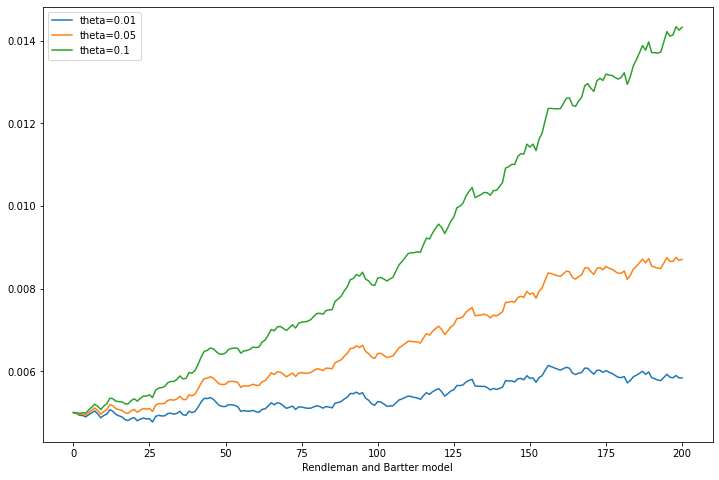

In [72]:
#by invoking %pylab IPython interpreter will import matplotlib and NumPy modules
%pylab inline
#plot
fig = plt.figure(figsize=(12, 8))

for theta in [0.01, 0.05, 0.1]:
    x, y = rendleman_bartter(0.005, theta, 0.05, T=10, N=200)
    plot(x,y, label='theta=%s'%theta)#plot the chart for different value of theta

pylab.legend(loc='upper left')
pylab.xlabel('Rendleman and Bartter model');

## The Brennan and Schwartz model

In [73]:
import math#to use mathematical functions we have to import math
import numpy as np#Numpy provides fast mathematical function processing

def brennan_schwartz(r0, K, theta, sigma, T=1., N=10, seed=777):    
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + \
            sigma*rates[-1]*math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)    #short rate for Brennan and Schwartz model evaulated here

    return range(N+1), rates

Populating the interactive namespace from numpy and matplotlib


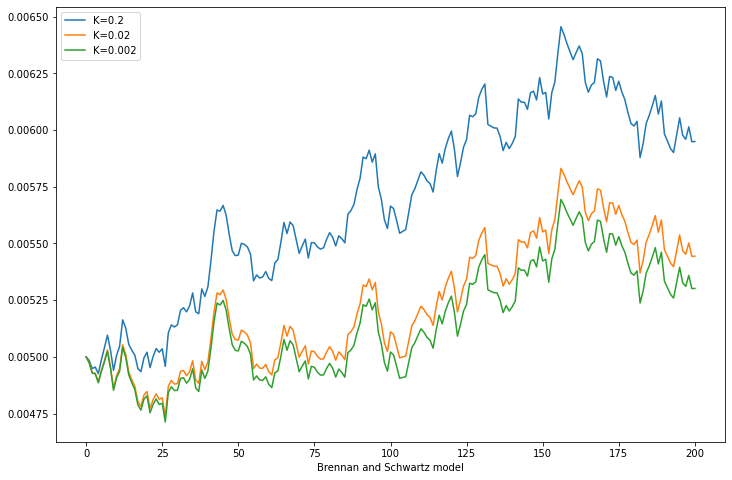

In [74]:
#by invoking %pylab IPython interpreter will import matplotlib and NumPy modules
%pylab inline
#plot
fig = plt.figure(figsize=(12, 8))

for K in [0.2, 0.02, 0.002]:
    x, y = brennan_schwartz(0.005, K, 0.006, 0.05, T=10, N=200)#brennan_schwartz method called
    plot(x,y, label='K=%s'%K)

pylab.legend(loc='upper left')
pylab.xlabel('Brennan and Schwartz model');

# Pricing a callable bond option

## Pricing a zero-coupon bond by the Vasicek model

In [75]:
#python implementation of zero coupon bond  prices with Vasicek model
import numpy as np#Numpy provides fast mathematical function processing
import math#to use mathematical functions we have to import math
#Zero coupon bond evaluated using exact_zcb method
def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    B = (1 - np.exp(-kappa*tau)) / kappa
    A = np.exp((theta-(sigma**2)/(2*(kappa**2)))*(B-tau) - \
               (sigma**2)/(4*kappa)*(B**2))#
    return A * np.exp(-r0*B)

In [76]:
Ts = np.r_[0.0:25.5:0.5]
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]#zero coupon bond for a period of 0 to 25 years with an interval of 0.5

Populating the interactive namespace from numpy and matplotlib


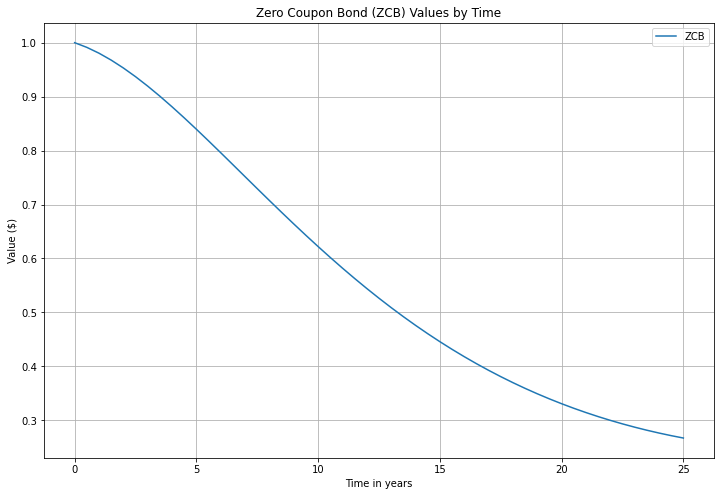

In [77]:
#by invoking %pylab IPython interpreter will import matplotlib and NumPy modules
%pylab inline

fig = plt.figure(figsize=(12, 8))
plt.title("Zero Coupon Bond (ZCB) Values by Time")
plt.plot(Ts, zcbs, label='ZCB')
plt.ylabel("Value ($)")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)
plt.show()#plot the graph

## Value of early-exercise

In [81]:
import math#to use mathematical functions we have to import math
#K is the price ratio of the strike price to the par value and R is the interest rate for the strike price
def exercise_value(K, R, t):#discounted early exercise value evaluated
    return K*math.exp(-R*t)

In [82]:
Ts = np.r_[0.0:25.5:0.5]#zero coupon bond for a period of 0 to 25 years with an interval of 0.5
Ks = [exercise_value(0.95, 0.015, t) for t in Ts]#strike ratio 0.95 ,initial interest rate 1.5%
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]

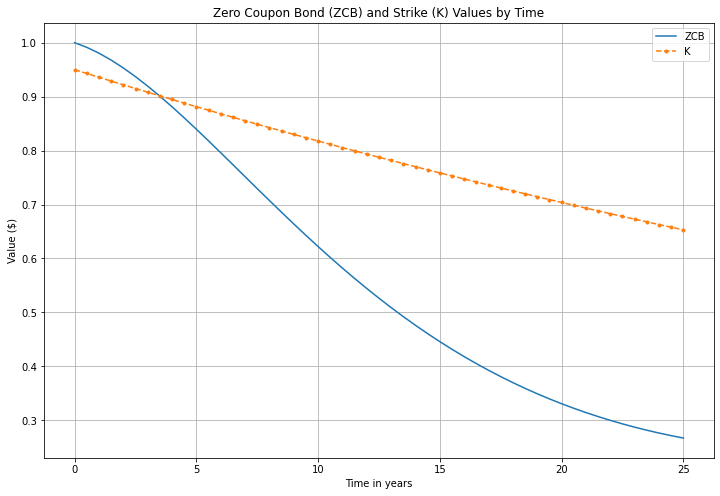

In [83]:
import matplotlib.pyplot as plt #Machine Learning library to create plots and data visualizations

fig = plt.figure(figsize=(12, 8))
plt.title("Zero Coupon Bond (ZCB) and Strike (K) Values by Time")
plt.plot(Ts, zcbs, label='ZCB')#plot the ZCB chart
plt.plot(Ts, Ks, label='K', linestyle="--", marker=".")
plt.ylabel("Value ($)")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)
plt.show()

## Policy iteration by finite differences

In [84]:
import math#to use mathematical functions we have to import math
import numpy as np #Numpy provides fast mathematical function processing
import scipy.stats as st#Algorithm library used for high level mathematics, plotting, and statistics


class VasicekCZCB:
    
    def __init__(self):
        self.norminv = st.distributions.norm.ppf
        self.norm = st.distributions.norm.cdf        
      #point of entry to kick start the pricing process
    def vasicek_czcb_values(self, r0, R, ratio, T, sigma, kappa, theta,
                            M, prob=1e-6, max_policy_iter=10, 
                            grid_struct_const=0.25, rs=None):
        (r_min, dr, N, dtau) = \
            self.vasicek_params(r0, M, sigma, kappa, theta,
                                T, prob, grid_struct_const, rs)
        r = np.r_[0:N]*dr + r_min
        v_mplus1 = np.ones(N)

        for i in range(1, M+1):
            K = self.exercise_call_price(R, ratio, i*dtau)
            eex = np.ones(N)*K
            (subdiagonal, diagonal, superdiagonal) = \
                self.vasicek_diagonals(
                    sigma, kappa, theta, r_min, dr, N, dtau)
            (v_mplus1, iterations) = \
                self.iterate(subdiagonal, diagonal, superdiagonal,
                             v_mplus1, eex, max_policy_iter)
        return r, v_mplus1
    #computes the implicit scheme parameters for the vasicek mode
    def vasicek_params(self, r0, M, sigma, kappa, theta, T,
                      prob, grid_struct_const=0.25, rs=None):l
        if rs is not None:
            (r_min, r_max) = (rs[0], rs[-1])
        else:
            (r_min, r_max) = self.vasicek_limits(
                r0, sigma, kappa, theta, T, prob)        

        dt = T/float(M)
        N = self.calculate_N(grid_struct_const, dt, sigma, r_max, r_min)
        dr = (r_max-r_min)/(N-1)

        return (r_min, dr, N, dt)
    
    def calculate_N(self, max_structure_const, dt, sigma, r_max, r_min):
        N = 0
        while True:
            N += 1
            grid_structure_interval = \
                dt*(sigma**2)/(((r_max-r_min)/float(N))**2)
            if grid_structure_interval > max_structure_const:
                break
        return N
    #computes the minimu and maximum of the vasicek interest rate process using normal distribution process
    def vasicek_limits(self, r0, sigma, kappa, theta, T, prob=1e-6):
        er = theta+(r0-theta)*math.exp(-kappa*T)
        variance = (sigma**2)*T if kappa==0 else \
                    (sigma**2)/(2*kappa)*(1-math.exp(-2*kappa*T))
        stdev = math.sqrt(variance)
        r_min = self.norminv(prob, er, stdev)
        r_max = self.norminv(1-prob, er, stdev)
        return (r_min, r_max)
#returns the diagonals of the implicit scheme of finite differences
    def vasicek_diagonals(self, sigma, kappa, theta, r_min,
                          dr, N, dtau):
        rn = np.r_[0:N]*dr + r_min
        subdiagonals = kappa*(theta-rn)*dtau/(2*dr) - \
                        0.5*(sigma**2)*dtau/(dr**2)
        diagonals = 1 + rn*dtau + sigma**2*dtau/(dr**2)
        superdiagonals = -kappa*(theta-rn)*dtau/(2*dr) - \
                        0.5*(sigma**2)*dtau/(dr**2)

        # Implement boundary conditions.
        if N > 0:
            v_subd0 = subdiagonals[0]
            superdiagonals[0] = superdiagonals[0]-subdiagonals[0]
            diagonals[0] += 2*v_subd0
            subdiagonals[0] = 0

        if N > 1:
            v_superd_last = superdiagonals[-1]
            superdiagonals[-1] = superdiagonals[-1] - subdiagonals[-1]
            diagonals[-1] += 2*v_superd_last
            superdiagonals[-1] = 0

        return (subdiagonals, diagonals, superdiagonals)
    #gives a list of boolean values
    def check_exercise(self, V, eex):
        return V > eex
    #returns discounted value of the strike price as a ratio
    def exercise_call_price(self, R, ratio, tau):
        K = ratio*np.exp(-R*tau)
        return K
     #updates the sub-diagonals, diagonals, and super diagonals for one iteration

    def vasicek_policy_diagonals(self, subdiagonal, diagonal, \
                                 superdiagonal, v_old, v_new, eex):
        has_early_exercise = self.check_exercise(v_new, eex)
        subdiagonal[has_early_exercise] = 0
        superdiagonal[has_early_exercise] = 0
        policy = v_old/eex
        policy_values = policy[has_early_exercise]
        diagonal[has_early_exercise] = policy_values
        return (subdiagonal, diagonal, superdiagonal)
    #performs scheme of finite differences by policy iteration based 
    def iterate(self, subdiagonal, diagonal, superdiagonal,
                v_old, eex, max_policy_iter=10):
        v_mplus1 = v_old
        v_m = v_old
        change = np.zeros(len(v_old))
        prev_changes = np.zeros(len(v_old))

        iterations = 0
        while iterations <= max_policy_iter:
            iterations += 1

            v_mplus1 = self.tridiagonal_solve(
                    subdiagonal, diagonal, superdiagonal, v_old)
            subdiagonal, diagonal, superdiagonal = \
                self.vasicek_policy_diagonals(
                    subdiagonal, diagonal, superdiagonal, 
                    v_old, v_mplus1, eex)

            is_eex = self.check_exercise(v_mplus1, eex)
            change[is_eex] = 1

            if iterations > 1:
                change[v_mplus1 != v_m] = 1

            is_no_more_eex = False if True in is_eex else True
            if is_no_more_eex:
                break

            v_mplus1[is_eex] = eex[is_eex]
            changes = (change == prev_changes)

            is_no_further_changes = all((x == 1) for x in changes)
            if is_no_further_changes:
                break

            prev_changes = change
            v_m = v_mplus1

        return v_mplus1, iterations-1
  
    # method for solving tridiagonal systems of equations.
    def tridiagonal_solve(self, a, b, c, d):
        nf = len(a)  # Number of equations
        ac, bc, cc, dc = map(np.array, (a, b, c, d))  # Copy the array
        for it in range(1, nf):
            mc = ac[it]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1] 
            dc[it] = dc[it] - mc*dc[it-1]

        xc = ac
        xc[-1] = dc[-1]/bc[-1]

        for il in range(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

        del bc, cc, dc  # Delete variables from memory

        return xc

In [85]:
r0 = 0.05
R = 0.05
ratio = 0.95
sigma = 0.03
kappa = 0.15
theta = 0.05
prob = 1e-6
M = 250
max_policy_iter=10
grid_struct_interval = 0.25
rs = np.r_[0.0:2.0:0.1]#interest between 0 to 2%

In [86]:
vasicek = VasicekCZCB()#object of class VasicekCZB instantiated
r, vals = vasicek.vasicek_czcb_values(
    r0, R, ratio, 1., sigma, kappa, theta, 
    M, prob, max_policy_iter, grid_struct_interval, rs)

Populating the interactive namespace from numpy and matplotlib


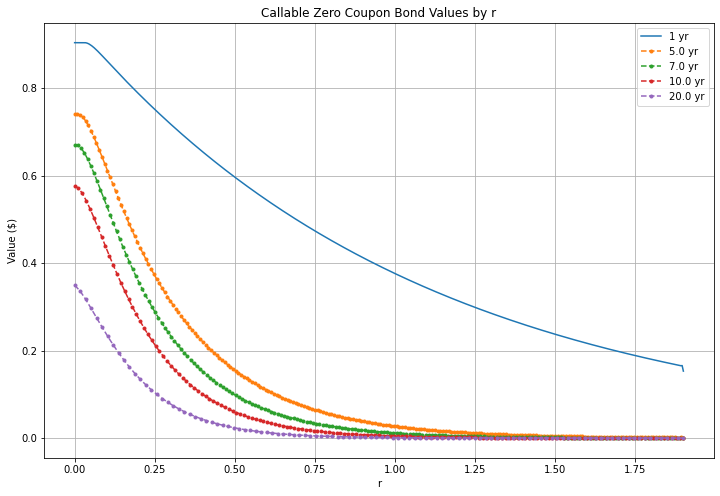

In [87]:
%pylab inline

fig = plt.figure(figsize=(12, 8))
plt.title("Callable Zero Coupon Bond Values by r")
plt.plot(r, vals, label='1 yr')
#loop for plotting charts for maturities of different number of  years
for T in [5., 7., 10., 20.]:
    r, vals = vasicek.vasicek_czcb_values(
        r0, R, ratio, T, sigma, kappa, theta, 
        M, prob, max_policy_iter, grid_struct_interval, rs)
    plt.plot(r, vals, label=str(T)+' yr', linestyle="--", marker=".")

plt.ylabel("Value ($)")
plt.xlabel("r")
plt.legend()
plt.grid(True)
plt.show()